In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import warnings
warnings.filterwarnings("ignore")

In [56]:
df_green = pd.read_csv("imputed_df.csv")

df_model = df_green[['Power (kW)', 'Total Cores', 'Year', 
                             'Processor Speed (MHz)', 'Accelerator/Co-Processor Cores',
                             'Energy Efficiency [GFlops/Watts]', 'Rmax [TFlop/s]']].copy()
print(df_model.info())
print(df_model.skew())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159 entries, 0 to 1158
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Power (kW)                        1159 non-null   float64
 1   Total Cores                       1159 non-null   int64  
 2   Year                              1159 non-null   int64  
 3   Processor Speed (MHz)             1159 non-null   int64  
 4   Accelerator/Co-Processor Cores    1159 non-null   float64
 5   Energy Efficiency [GFlops/Watts]  1159 non-null   float64
 6   Rmax [TFlop/s]                    1159 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 63.5 KB
None
Power (kW)                          5.286962
Total Cores                         6.387200
Year                               -0.284299
Processor Speed (MHz)               0.318222
Accelerator/Co-Processor Cores      5.973370
Energy Efficiency [GFlops/Watts]    1.695445
R

Train R² 0.8444
Test R² 0.8339
Train RMSE 0.4015
Test RMSE 0.4042
Train MAE 0.3052
Test MAE 0.3178


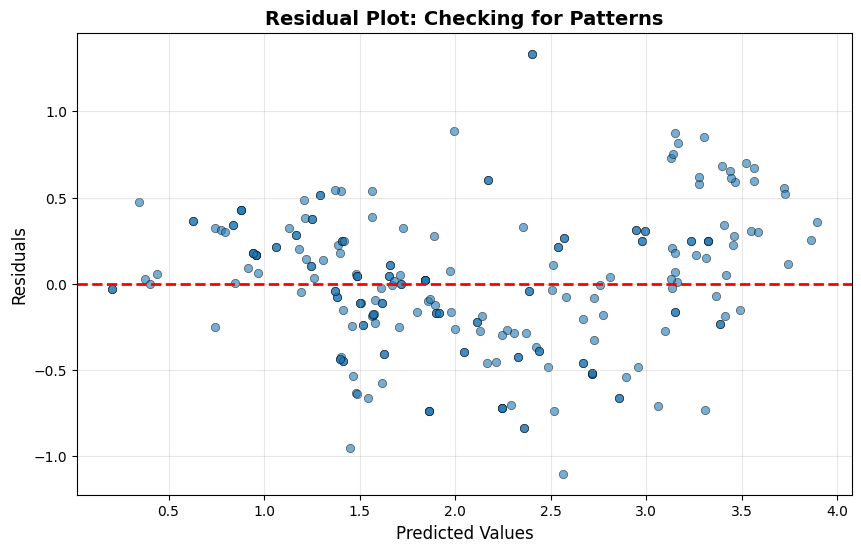

In [ ]:
#MODEL 2 with another fetaure
df_green = pd.read_csv("imputed_df.csv")
df_green['has_accelerator'] = df_green['Accelerator/Co-Processor'].notna().astype(int)
df_green.loc[df_green['Accelerator/Co-Processor'].isna(), 'Accelerator/Co-Processor Cores'] = 0
#print(df_green['has_accelerator'].value_counts())
#print(df_green['Accelerator/Co-Processor Cores'].value_counts())
df_model = df_green[['Power (kW)', 'Total Cores', 'Year', 
                             'Processor Speed (MHz)', 'Accelerator/Co-Processor Cores',
                             'Energy Efficiency [GFlops/Watts]', 'Rmax [TFlop/s]', 'has_accelerator']].copy()
df_model['log_power(kw)'] = np.log1p(df_model['Power (kW)'])
df_model['log_total_cores'] = np.log1p(df_model['Total Cores'])
df_model['log_accelerator_coprocessor_cores'] = np.log1p(df_model['Accelerator/Co-Processor Cores'])
df_model['log_energy_efficiency'] = np.log1p(df_model['Energy Efficiency [GFlops/Watts]'])
df_model['log_Rmax [TFlop/s]'] = np.log1p(df_model['Rmax [TFlop/s]'])
features = ['Year', 'Processor Speed (MHz)', 'log_power(kw)',
                   'log_total_cores', 'log_accelerator_coprocessor_cores', 'has_accelerator']
target = 'log_energy_efficiency'
        
X = df_model[features]
y = df_model[target]
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
        
model = LinearRegression()
model.fit(X_train_scaled, y_train)
        

y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)
        

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
print("Train R²", f"{train_r2:.4f}")
print("Test R²", f"{test_r2:.4f}")
print("Train RMSE", f"{train_rmse:.4f}")
print("Test RMSE", f"{test_rmse:.4f}")
print("Train MAE", f"{train_mae:.4f}")
print("Test MAE", f"{test_mae:.4f}")
# Residual plot
residuals = y_test - y_pred_test

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot: Checking for Patterns', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.show()

In [57]:
df_model['log_power(kw)'] = np.log1p(df_model['Power (kW)'])
df_model['log_total_cores'] = np.log1p(df_model['Total Cores'])
df_model['log_accelerator_coprocessor_cores'] = np.log1p(df_model['Accelerator/Co-Processor Cores'])
df_model['log_energy_efficiency'] = np.log1p(df_model['Energy Efficiency [GFlops/Watts]'])
df_model['log_Rmax [TFlop/s]'] = np.log1p(df_model['Rmax [TFlop/s]'])
df_green['Accelerator/Co-Processor Cores'].fillna(0, inplace=True)
df_model['has_accelerator'] = (df_green['Accelerator/Co-Processor Cores'] > 0).astype(int)
df_model.skew()

Power (kW)                           5.286962
Total Cores                          6.387200
Year                                -0.284299
Processor Speed (MHz)                0.318222
Accelerator/Co-Processor Cores       5.973370
Energy Efficiency [GFlops/Watts]     1.695445
Rmax [TFlop/s]                       9.425485
log_power(kw)                        0.183219
log_total_cores                      1.040402
log_accelerator_coprocessor_cores   -0.140179
log_energy_efficiency                0.467266
log_Rmax [TFlop/s]                   1.730817
has_accelerator                      0.000000
dtype: float64

Train R² 0.7085
Test R² 0.6912
Train RMSE 0.5494
Test RMSE 0.5511
Train MAE 0.4312
Test MAE 0.4251


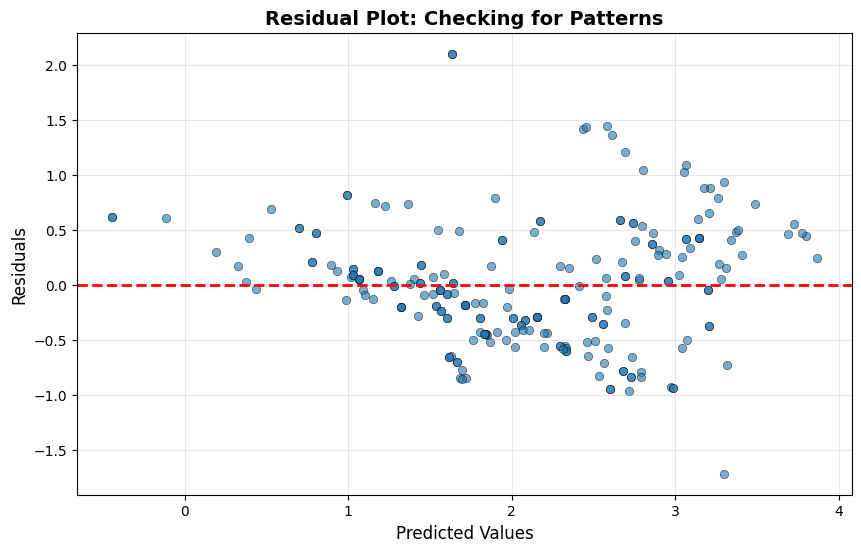

In [58]:
#MODEL A
features = ['Year', 'Processor Speed (MHz)', 'log_power(kw)',
                   'log_total_cores', 'log_accelerator_coprocessor_cores']
target = 'log_energy_efficiency'
        
X = df_model[features]
y = df_model[target]
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
        
model = LinearRegression()
model.fit(X_train_scaled, y_train)
        

y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)
        

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
print("Train R²", f"{train_r2:.4f}")
print("Test R²", f"{test_r2:.4f}")
print("Train RMSE", f"{train_rmse:.4f}")
print("Test RMSE", f"{test_rmse:.4f}")
print("Train MAE", f"{train_mae:.4f}")
print("Test MAE", f"{test_mae:.4f}")
residuals = y_test - y_pred_test

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot: Checking for Patterns', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.show()

Train R² 0.7085
Test R² 0.6912
Train RMSE 0.5494
Test RMSE 0.5511
Train MAE 0.4312
Test MAE 0.4251


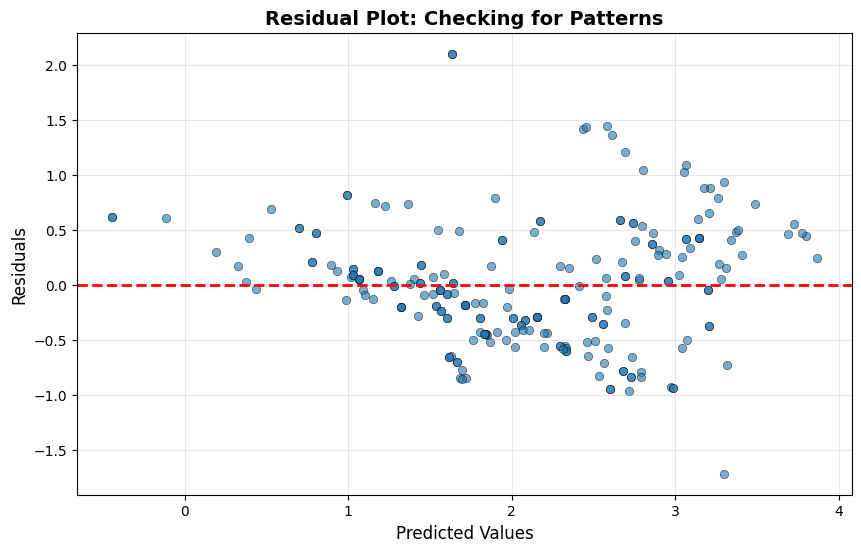

In [59]:
features = ['Year', 'Processor Speed (MHz)', 'log_power(kw)',
                   'log_total_cores', 'log_accelerator_coprocessor_cores', 'has_accelerator']
target = 'log_energy_efficiency'
        
X = df_model[features]
y = df_model[target]
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
        
model = LinearRegression()
model.fit(X_train_scaled, y_train)
        

y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)
        

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
print("Train R²", f"{train_r2:.4f}")
print("Test R²", f"{test_r2:.4f}")
print("Train RMSE", f"{train_rmse:.4f}")
print("Test RMSE", f"{test_rmse:.4f}")
print("Train MAE", f"{train_mae:.4f}")
print("Test MAE", f"{test_mae:.4f}")
# Residual plot
residuals = y_test - y_pred_test

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot: Checking for Patterns', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.show()

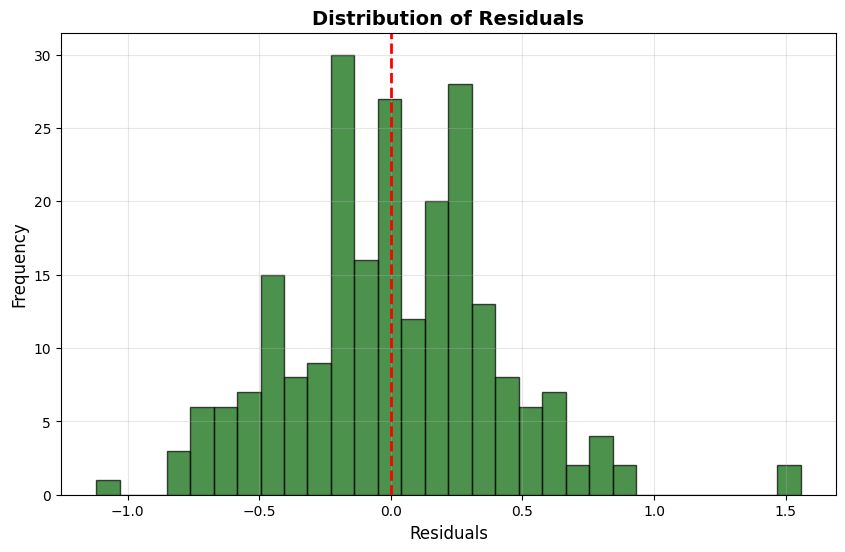

In [43]:
# Quick normality check
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='darkgreen')
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Residuals', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.grid(alpha=0.3)
plt.show()

In [44]:
# Get feature importance
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
})
coef_df = coef_df.sort_values('Coefficient', key=abs, ascending=False)
print(coef_df)

                             Feature  Coefficient
0                               Year     0.478950
5                    has_accelerator     0.477790
2                      log_power(kw)    -0.442896
3                    log_total_cores     0.317433
4  log_accelerator_coprocessor_cores     0.111979
1              Processor Speed (MHz)    -0.003828
